In [1]:
# 20230331_beads_box15 box size 15 gradient 25000 snr 2
# 20230331_beads_box box size 31 gradient 10000 snr 3

config = {
    'dirname': '20230331_beads',
    'box_size': 31,
    'gradient': 10000,
    'snr': 2
}

# config = {
#     'dirname': '20230331_beads_box15px',
#     'box_size': 15,
#     'gradient': 10000,
#     'snr': 2
# }

# config = {
#     'dirname': '20230331_beads_box7',
#     'box_size': 7,
#     'gradient': 10000,
#     'snr': 2
# }

In [2]:
psf_params = {
    'res': 110
}

In [3]:
dirname = config['dirname']
bead_stacks = [
    f'/home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20200723_OpenFrame_3D_beads/glass_beads_agarose_1/glass_beads_agarose_1_MMStack_Default.ome.tif',
]

In [4]:
# Write bead stack data
import matplotlib.pyplot as plt
import os
import numpy as np
from tifffile import imread, imwrite
import sys
import h5py
import pandas as pd
from tqdm import tqdm
sys.path.append('/home/miguel/Projects/uni/phd/smlm_z/smlm-z/src/smlm_z/pipelines')

from preprocessing.nodes import extract_training_stacks
from sklearn.metrics import euclidean_distances

picasso_path = '/home/miguel/Projects/uni/phd/smlm_z/picasso/venv/bin/picasso'
out_stack_path = []

all_spots = []
all_locs = []
all_stacks = []

for bead_stack_path in tqdm(bead_stacks):
    bname = os.path.basename(bead_stack_path)

    bead_stack = imread(bead_stack_path)

    im_slice = bead_stack[bead_stack.shape[0]//2]
    slice_path = bead_stack_path.replace('.ome', '_slice.ome')
    if not os.path.exists(slice_path):
        imwrite(slice_path, im_slice.astype(np.uint16))
    

    spots_path = slice_path.replace('.ome.tif', '.ome_spots.hdf5')
    locs_path = slice_path.replace('.ome.tif', '.ome_locs.hdf5')

    if not os.path.exists(spots_path) or not os.path.exists(locs_path):
        print('Running picasso')
        print(f"{picasso_path} localize -b {config['box_size']} -d 0 -g {config['gradient']} -px {int(psf_params['res'])} {slice_path}")
        # Run picasso on bead stack
        ! {picasso_path} localize -b {config['box_size']} -d 0 -g {config['gradient']} -px {int(psf_params['res'])} {slice_path}
            
    with h5py.File(spots_path) as f:
        spots = np.array(f['spots'])

    locs = pd.read_hdf(locs_path, key='locs')
    locs['fname'] = bname
    coords = locs[['x', 'y']].to_numpy()
    dists = euclidean_distances(coords, coords)
    np.fill_diagonal(dists, np.inf)
    min_dists = dists.min(axis=1)
    
    error_margin = 0.8
    min_seperation = (np.sqrt(2)  * config['box_size']) * error_margin
    idx = np.argwhere(min_dists > min_seperation).squeeze()
    print(len(idx) / len(min_dists))
    locs = locs.iloc[idx]
    spots = spots[idx]
    
    parameters = {
        'picasso': {
            'spot_size': config['box_size'],
            'localised_frame': bead_stack.shape[0]//2
        },
        'DEBUG': False
    }
    stacks = extract_training_stacks(spots, bead_stack, parameters)
    
    all_spots.append(spots)
    all_locs.append(locs)
    all_stacks.append(stacks)

min_stack_length = min(list(map(lambda s: s.shape[1], all_stacks)))
all_stacks = [s[:, :min_stack_length] for s in all_stacks]
    
all_spots = np.concatenate(all_spots)
all_locs = pd.concat(all_locs)
all_stacks = np.concatenate(all_stacks)

print(all_spots.shape)
print(all_locs.shape)
print(all_stacks.shape)

  0%|                                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

Running picasso
/home/miguel/Projects/uni/phd/smlm_z/picasso/venv/bin/picasso localize -b 31 -d 0 -g 10000 -px 110 /home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20200723_OpenFrame_3D_beads/glass_beads_agarose_1/glass_beads_agarose_1_MMStack_Default_slice.ome.tif
    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           /home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20200723_OpenFrame_3D_beads/glass_beads_agarose_1/glass_beads_agarose_1_MMStack_Default_slice.ome.tif
3        box_side_length 31        
4        fit_method      mle       
5        gradient        10000     
6        drift           0         
7        roi     

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.40s/it]

(19, 31, 31)
(19, 13)
(19, 200, 31, 31)


3.823529411764706 19.41176470588235


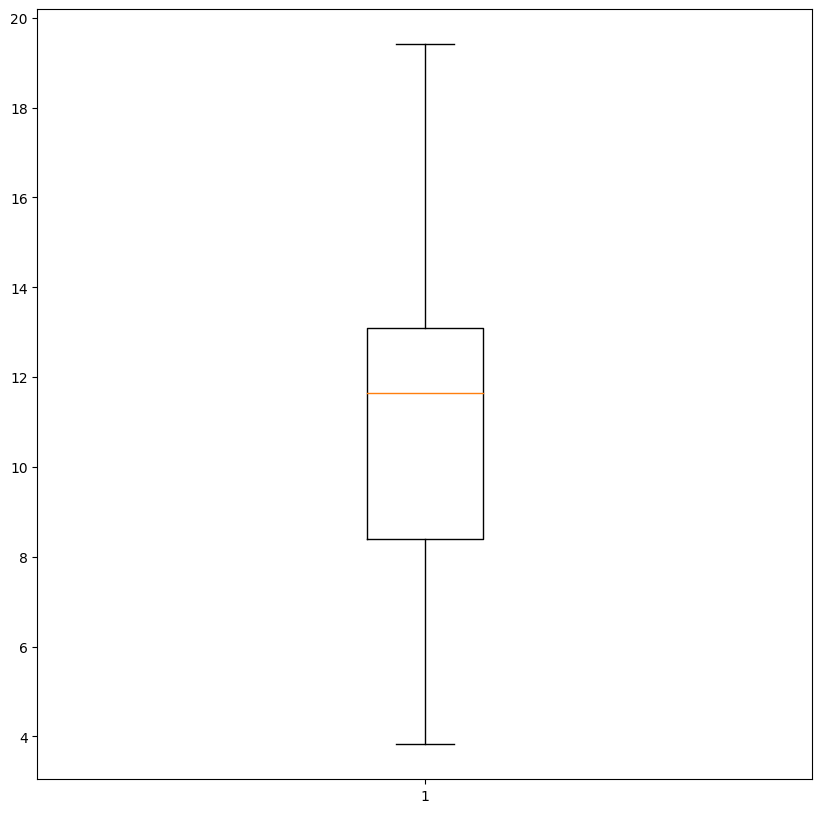

(14, 31, 31)
(14, 13)
(14, 200, 31, 31)


In [13]:
def snr(psf):
    return psf.max() / np.median(psf)

snrs = np.array([snr(psf) for psf in all_stacks])
print(min(snrs), max(snrs))
plt.boxplot(snrs)
plt.show()
min_snrs = config['snr']
min_snrs = 8

idx = np.argwhere(snrs > min_snrs).squeeze()
spots = all_spots[idx]
locs = all_locs.iloc[idx]
stacks = all_stacks[idx]

print(spots.shape)
print(locs.shape)
print(stacks.shape)

In [14]:
# import seaborn as sns
# zs = (np.arange(0, stacks.shape[1]) * 20)
# # zs = np.repeat(zs, stacks.shape[0], axis=0)

# from sklearn.decomposition import PCA


# stacks_flat = np.concatenate(stacks)
# # zs = zs.reshape((stacks_flat.shape[0], -1)).squeeze()
# stacks_flat = stacks_flat.reshape((stacks_flat.shape[0], -1))


# pca_func = PCA().fit(stacks_flat)

# for stack in stacks:
#     pca = pca_func.transform(stack.reshape(stack.shape[0], -1))
#     sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=zs)
# plt.legend([],[], frameon=False)
# plt.show()



(14, 200, 31, 31)


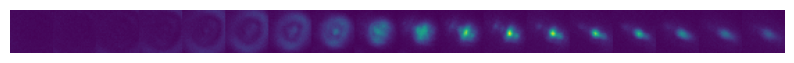

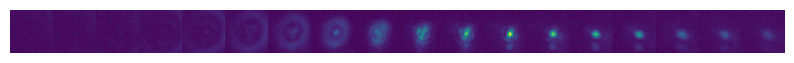

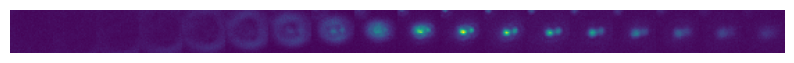

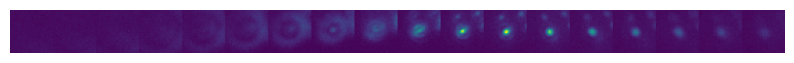

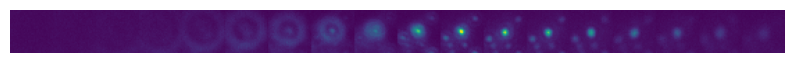

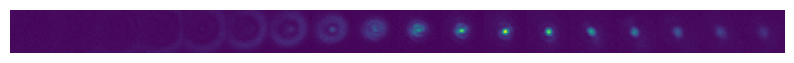

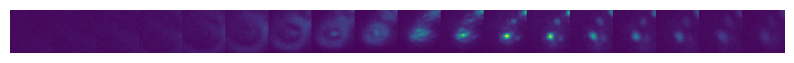

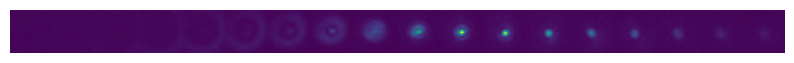

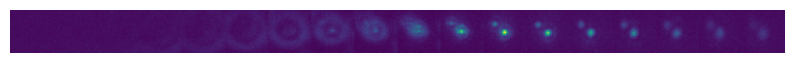

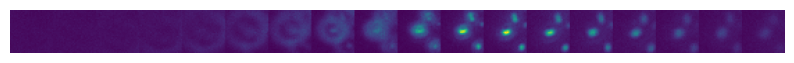

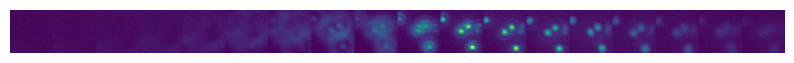

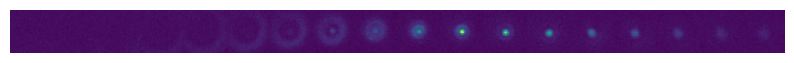

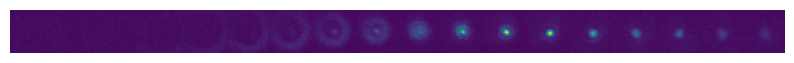

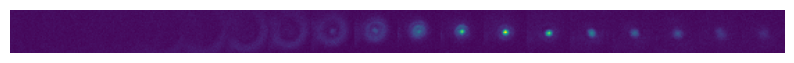

In [15]:
from data.visualise import grid_psfs, show_psf_axial
import seaborn as sns

# sns.scatterplot(data=locs, x='x', y='y')
# plt.show()
plt.rcParams['figure.figsize'] = [10, 10]
print(stacks.shape)
for psf in stacks:
    show_psf_axial(psf)

In [8]:
outpath = f"/home/miguel/Projects/uni/data/smlm_3d/{config['dirname']}/combined"
os.makedirs(outpath, exist_ok=True)

out_locs = os.path.join(outpath, 'locs.hdf')
out_stacks = os.path.join(outpath, 'stacks.ome.tif')

print(stacks.shape)
imwrite(out_stacks, stacks, compress=6)

print(locs.shape)
locs.to_hdf(out_locs, key='locs')

(77, 150, 31, 31)
(77, 13)


In [9]:
import yaml
yaml_config = {
    'stacks': {
        'type': 'smlm_z.extras.datasets.SpotsDataSet',
        'filepath': out_stacks,
        'key': 'spots'
    },
    'locs': {
        'type': 'pandas.HDFDataSet',
        'filepath': out_locs,
        'key': 'locs'
    },
}
for k, v in yaml_config.items():
    try:
        assert os.path.exists(v['filepath'])
    except AssertionError as e:
        print(v['filepath'], 'does not exist')
        break

import sys
yaml.dump(yaml_config, sys.stdout)

locs:
  filepath: /home/miguel/Projects/uni/data/smlm_3d/20230331_beads/combined/locs.hdf
  key: locs
  type: pandas.HDFDataSet
stacks:
  filepath: /home/miguel/Projects/uni/data/smlm_3d/20230331_beads/combined/stacks.ome.tif
  key: spots
  type: smlm_z.extras.datasets.SpotsDataSet


In [10]:
imgs = stacks[0]
print(imgs.shape)

(150, 31, 31)


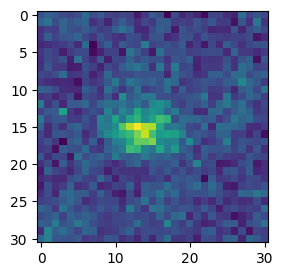

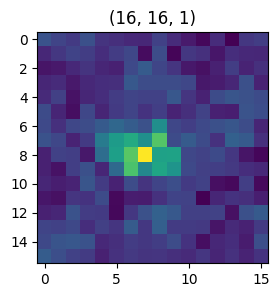

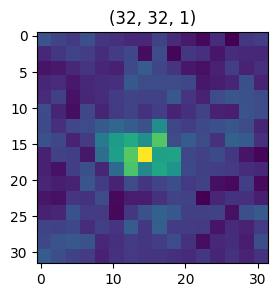

array([[[0.04993451],
        [0.04993451],
        [0.04798235],
        ...,
        [0.04632228],
        [0.04714722],
        [0.04714722]],

       [[0.04993451],
        [0.04993451],
        [0.04798235],
        ...,
        [0.04632228],
        [0.04714722],
        [0.04714722]],

       [[0.04440125],
        [0.04440125],
        [0.04634219],
        ...,
        [0.04461424],
        [0.0444298 ],
        [0.0444298 ]],

       ...,

       [[0.04836818],
        [0.04836818],
        [0.05009141],
        ...,
        [0.04316058],
        [0.04928163],
        [0.04928163]],

       [[0.05124655],
        [0.05124655],
        [0.04933608],
        ...,
        [0.0440229 ],
        [0.04574094],
        [0.04574094]],

       [[0.05124655],
        [0.05124655],
        [0.04933608],
        ...,
        [0.0440229 ],
        [0.04574094],
        [0.04574094]]])

In [11]:
from skimage.transform import rescale
plt.rcParams['figure.figsize'] = [3, 3]
def bin_pixels(img):
    subsample_ratio = 2
    new_shape = [s//subsample_ratio for s in img.shape[0:2]] + [1]
    new_img = rescale(img, 1/subsample_ratio, anti_aliasing=False)
    
    upscaled_img = rescale(new_img, (subsample_ratio, subsample_ratio, 1), anti_aliasing=False, order=0)
    plt.imshow(img)
    plt.show()
    plt.imshow(new_img)
    plt.title(new_img.shape)

    plt.show()
    
    plt.imshow(upscaled_img)
    plt.title(upscaled_img.shape)
    plt.show()
    return upscaled_img
bin_pixels(imgs[0][:, :, np.newaxis])
    